In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install 'h5py<3.0.0'
!pip install sklearn_crfsuite
# !pip install tensorflow==1.15.2 keras==2.3.1
!pip3 install glove-python-binary
!pip install git+https://www.github.com/keras-team/keras-contrib.git --upgrade
!pip install catboost

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-8htbvmwy
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-8htbvmwy
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=dfedae816658150521228942c652782d6dcf745af46a703948d8f80fda9d7020
  Stored in directory: /tmp/pip-ephem-wheel-cache-67s8ndxf/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Found existing installation: keras-contrib 2.0.8
    Uninstalling keras-contrib-2.0.8:
      Successfully uninstalled keras-contrib-2.0.8


In [3]:
!gdown --id 1cCXjHX9FAgouF0DWuWPO5qyBHVZDkXTQ
!gdown --id 1RFNBRcly96omdpNtYlEK6O1EuQs3ux7t
!gdown --id 1AnLqXtSyJNBK7YmwuW6L6z2OYhE4RPTV

Downloading...
From: https://drive.google.com/uc?id=1cCXjHX9FAgouF0DWuWPO5qyBHVZDkXTQ
To: /content/NER_PAD_agg_test.csv
2.92MB [00:00, 13.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RFNBRcly96omdpNtYlEK6O1EuQs3ux7t
To: /content/NER_PAD_agg_train.csv
11.7MB [00:00, 25.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AnLqXtSyJNBK7YmwuW6L6z2OYhE4RPTV
To: /content/NER_PAD_agg.csv
14.6MB [00:00, 31.4MB/s]


In [3]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from nltk.corpus import stopwords
import pandas as pd
import pickle
import re
import datetime
import os
import numpy as np

from keras.optimizers import Adam
from keras.models import *
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_marginal_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import gensim.downloader as api
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from gensim.models import Word2Vec
from glove import Corpus, Glove
from tqdm import tqdm

Using TensorFlow backend.


In [4]:
df = pd.read_csv('NER_PAD_agg.csv', converters={'tokens': eval, 'ner_tags': eval})
train = pd.read_csv('NER_PAD_agg_train.csv', converters={'tokens': eval, 'ner_tags': eval})
test = pd.read_csv('NER_PAD_agg_test.csv', converters={'tokens': eval, 'ner_tags': eval})

all_dfs = [df, train, test]

In [5]:
def find_token(x):
    SUFFIXES = ['_DET', '_NOUN', '_VERB', '_ADJ', '']
    res = []
    for w in x['tokens']:
        has_found = False
        for suffix in SUFFIXES:
            if w + suffix in w2v.wv.vocab.keys():
                res.append(w2v.wv.vocab[w + suffix].index)
                has_found = True
                break
        if not has_found:
            res.append(0)
    return res


all_tags = set()
for _, row in df.iterrows():
    for tag in row.ner_tags:
        all_tags.add(tag)
all_tags = sorted(list(all_tags))
tag_to_idx = {t: i for i, t in enumerate(all_tags)}
label_list = {i: t for i, t in enumerate(all_tags)}
labels = list(tag_to_idx.keys())
labels.remove('O')
labels = sorted(labels, key=lambda name: (name[1:], name[0]))
int_labels = list(tag_to_idx.values())
int_labels.remove(tag_to_idx['O'])
int_labels = sorted(int_labels)

In [ ]:
pretrained_w2v = api.load("word2vec-ruscorpora-300")
pretrained_w2v.save_word2vec_format('tmp')

In [ ]:
def add_suffix(x):
    SUFFIXES = ['_DET', '_NOUN', '_VERB', '_ADJ']
    res = []
    for w in x['tokens']:
        has_found = False
        for suffix in SUFFIXES:
            if w + suffix in pretrained_w2v.vocab.keys():
                res.append(w + suffix)
                has_found = True
                break
        if not has_found:
            res.append(w)
    return res

for d in all_dfs:
    d['tokens_with_suffix'] = d.apply(add_suffix, axis=1)

In [ ]:
from gensim.models import Word2Vec

w2v = Word2Vec(sentences=df['tokens_with_suffix'], size=300, window=15, min_count=2)

In [ ]:
w2v.intersect_word2vec_format('tmp')
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)

In [ ]:
for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_token, axis=1)

In [ ]:
df

,id,tokens,ner_tags,tokens_with_suffix,encoded_ner_tags,int_tokens
0,SV990125172_ОРГ__INM_18'09'58_1.pdf,"[l, *, универсальный, приложение, №, 1, постан...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-D...","[l, *, универсальный_ADJ, приложение_NOUN, №, ...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[3, 66, 494, 64, 1, 0, 83, 59, 94, 2904, 441, ..."
1,SS528581_ОРГ__INM_17'05'39_A.pdf,"[l, лист, согласования, стр., 1, 1, 2, 9, *, 0...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[l, лист_NOUN, согласования, стр., 1, 1, 2, 9,...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[3, 47, 35, 193, 0, 0, 4, 41, 66, 11, 17, 113,..."
2,SF435712_ОРГ__INM_15'25'41_A.pdf,"[l, приложение, №, постановлению, правительств...","[O, O, O, O, O, O, O, O, O, B-DOCNUM, B-DOCDAT...","[l, приложение_NOUN, №, постановлению, правите...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 7, 6, 13,...","[3, 64, 1, 83, 59, 290, 1752, 74, 1, 0, 133, 2..."
3,SV990124943_ОРГ__INM_19'00'43_A.pdf,"[l, акционерное, общество, регистраторское, об...","[O, O, O, O, O, B-DOCCPTY, O, O, O, O, O, O, O...","[l, акционерное, общество_NOUN, регистраторско...","[15, 15, 15, 15, 15, 3, 15, 15, 15, 15, 15, 15...","[3, 112, 43, 6621, 43, 1315, 0, 56, 80, 0, 189..."
4,S29013419_ОРИГИНАЛ__IND_1_22.05.12'21'36.pdf,"[l, *, 000стандарт, безопасности, адрес:, 1973...","[O, O, O, B-DOCCPTY, O, O, O, O, O, O, O, O, O...","[l, *, 000стандарт, безопасности, адрес:, 1973...","[15, 15, 15, 3, 15, 15, 15, 15, 15, 15, 15, 15...","[3, 66, 14721, 4486, 28, 2677, 277, 1137, 8911..."
...,...,...,...,...,...,...
3995,SV990121575_ОРГ__INM_18'45'08_3.pdf,"[l, экземпляр, аостс, стс, отчет, роялти, 2, к...","[O, O, O, O, O, O, O, O, O, O, O, B-DOCAGRNUM,...","[l, экземпляр_NOUN, аостс, стс_NOUN, отчет_NOU...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[3, 361, 8542, 418, 970, 1293, 4, 1828, 1537, ..."
3996,SV990121572_ОРГ__INM_18'45'08_3.pdf,"[l, ао, стс, отчет, роялти, 3, квартал, лиценз...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[l, ао_NOUN, стс_NOUN, отчет_NOUN, роялти_NOUN...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[3, 67, 418, 970, 1293, 14, 1828, 1537, 93, 1,..."
3997,SV990121520_ОРГ__INM_16'31'06_3.pdf,"[l, экземпляр, ао, стс, ао, стс, отчет, роялти...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-D...","[l, экземпляр_NOUN, ао_NOUN, стс_NOUN, ао_NOUN...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[3, 361, 67, 418, 67, 418, 970, 1293, 14, 1787..."
3998,SV990121573_ОРГ__INM_18'45'08_3.pdf,"[l, экземпляр, аостс, стс, отчет, п, роялти, 4...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[l, экземпляр_NOUN, аостс, стс_NOUN, отчет_NOU...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[3, 361, 8542, 418, 970, 19, 1293, 17, 0, 16, ..."


In [8]:
import warnings

warnings.filterwarnings("ignore")

In [7]:
def focal_loss(gamma=2., alpha=1.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## PRETRAINED W2V(not fixed)

In [ ]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 943, 300)          7440900   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 943, 200)          320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 943, 16)           3216      
_________________________________________________________________
crf_2 (CRF)                  (None, 943, 16)           560       
Total params: 7,765,476
Trainable params: 7,765,476
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('best_model.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 42s 15ms/step - loss: 0.7843 - crf_marginal_accuracy: 0.2648 - val_loss: 0.6091 - val_crf_marginal_accuracy: 0.8945
Epoch 2/30
2880/2880 [==============================] - 39s 13ms/step - loss: 0.5570 - crf_marginal_accuracy: 0.4671 - val_loss: 0.4561 - val_crf_marginal_accuracy: 0.1528
Epoch 3/30
2880/2880 [==============================] - 39s 13ms/step - loss: 0.4077 - crf_marginal_accuracy: 0.7324 - val_loss: 0.3206 - val_crf_marginal_accuracy: 0.9415
Epoch 4/30
2880/2880 [==============================] - 39s 13ms/step - loss: 0.2823 - crf_marginal_accuracy: 0.9513 - val_loss: 0.2279 - val_crf_marginal_accuracy: 0.9590
Epoch 5/30
2880/2880 [==============================] - 39s 13ms/step - loss: 0.2018 - crf_marginal_accuracy: 0.9687 - val_loss: 0.1798 - val_crf_marginal_accuracy: 0.9683
Epoch 6/30
2880/2880 [==============================] - 39s 13ms/step - loss: 0.1508 - crf_ma

In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.6794    0.5933    0.6335       150
 I-DOCAGRDATE     0.6455    0.8068    0.7172        88
  B-DOCAGRNUM     0.6899    0.6089    0.6469       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.7548    0.5350    0.6262      1243
  I-DOCAMOUNT     0.7153    0.5065    0.5930       620
    B-DOCCPTY     0.8613    0.8874    0.8742       595
    I-DOCCPTY     0.8724    0.8972    0.8846       564
 B-DOCCPTYINN     0.8170    0.9184    0.8648       282
B-DOCCUSTOMER     0.9111    0.8916    0.9012       609
I-DOCCUSTOMER     0.9326    0.9286    0.9306       462
    B-DOCDATE     0.8528    0.8264    0.8394       645
    I-DOCDATE     0.8561    0.9636    0.9067       605
     B-DOCNUM     0.8995    0.6052    0.7236       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8331    0.7497    0.7892      6700
    macro avg     0.6992    0.6646    0.6761      6700
 weighte

## PRETRAINED W2V(fixed)

In [ ]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 943, 300)          7440900   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 943, 200)          320800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 943, 16)           3216      
_________________________________________________________________
crf_3 (CRF)                  (None, 943, 16)           560       
Total params: 7,765,476
Trainable params: 324,576
Non-trainable params: 7,440,900
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('best_model_fixed_embeds.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 40s 14ms/step - loss: 0.7059 - crf_marginal_accuracy: 0.0202 - val_loss: 0.4837 - val_crf_marginal_accuracy: 0.8589
Epoch 2/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.4329 - crf_marginal_accuracy: 0.7772 - val_loss: 0.3297 - val_crf_marginal_accuracy: 0.9113
Epoch 3/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.3150 - crf_marginal_accuracy: 0.9315 - val_loss: 0.2545 - val_crf_marginal_accuracy: 0.9360
Epoch 4/30
2880/2880 [==============================] - 37s 13ms/step - loss: 0.2577 - crf_marginal_accuracy: 0.9472 - val_loss: 0.2153 - val_crf_marginal_accuracy: 0.9522
Epoch 5/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.2233 - crf_marginal_accuracy: 0.9555 - val_loss: 0.1925 - val_crf_marginal_accuracy: 0.9511
Epoch 6/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.1989 - crf_ma

In [ ]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.3111    0.5600    0.4000       150
 I-DOCAGRDATE     0.5426    0.7955    0.6452        88
  B-DOCAGRNUM     0.2834    0.6760    0.3993       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.3086    0.7385    0.4353      1243
  I-DOCAMOUNT     0.4029    0.8565    0.5480       620
    B-DOCCPTY     0.4643    0.8420    0.5986       595
    I-DOCCPTY     0.6881    0.8528    0.7617       564
 B-DOCCPTYINN     0.5408    0.8936    0.6738       282
B-DOCCUSTOMER     0.7301    0.8752    0.7961       609
I-DOCCUSTOMER     0.7712    0.9264    0.8417       462
    B-DOCDATE     0.5693    0.7705    0.6548       645
    I-DOCDATE     0.7568    0.9719    0.8509       605
     B-DOCNUM     0.6560    0.6298    0.6426       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.4957    0.8081    0.6144      6700
    macro avg     0.4683    0.6926    0.5499      6700
 weighte

## W2V(not fixed, window=5, min_count=2) + BILSTM + CRF

In [15]:
w2v = Word2Vec(sentences=df['tokens'], size=50, window=5, min_count=2)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_token, axis=1)

In [ ]:
from keras.optimizers import Adam
from keras.models import *
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_marginal_accuracy

MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 943, 50)           1240150   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 943, 200)          120800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 943, 16)           3216      
_________________________________________________________________
crf_5 (CRF)                  (None, 943, 16)           560       
Total params: 1,364,726
Trainable params: 1,364,726
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('best_model.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 43s 15ms/step - loss: 0.7996 - crf_marginal_accuracy: 0.5780 - val_loss: 0.6023 - val_crf_marginal_accuracy: 0.9577
Epoch 2/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.5411 - crf_marginal_accuracy: 0.9492 - val_loss: 0.4425 - val_crf_marginal_accuracy: 0.9568
Epoch 3/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.4049 - crf_marginal_accuracy: 0.9545 - val_loss: 0.3401 - val_crf_marginal_accuracy: 0.9477


In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.0000    0.0000    0.0000       150
 I-DOCAGRDATE     0.0000    0.0000    0.0000        88
  B-DOCAGRNUM     0.0008    0.0056    0.0013       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.0615    0.8294    0.1145      1243
  I-DOCAMOUNT     0.0000    0.0000    0.0000       620
    B-DOCCPTY     0.0642    0.6286    0.1165       595
    I-DOCCPTY     0.0000    0.0000    0.0000       564
 B-DOCCPTYINN     0.0000    0.0000    0.0000       282
B-DOCCUSTOMER     0.0481    0.1839    0.0763       609
I-DOCCUSTOMER     0.8505    0.3571    0.5030       462
    B-DOCDATE     0.1011    0.4620    0.1659       645
    I-DOCDATE     0.3557    0.5686    0.4377       605
     B-DOCNUM     0.4756    0.3886    0.4277       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.0834    0.3848    0.1371      6700
    macro avg     0.1305    0.2283    0.1229      6700
 weighte

## W2V(fixed, window=5, min_count=2) + BILSTM + CRF

In [ ]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 943, 50)           1240150   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 943, 200)          120800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 943, 16)           3216      
_________________________________________________________________
crf_6 (CRF)                  (None, 943, 16)           560       
Total params: 1,364,726
Trainable params: 124,576
Non-trainable params: 1,240,150
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('best_model_fixed_embeds.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 42s 15ms/step - loss: 0.8119 - crf_marginal_accuracy: 0.1154 - val_loss: 0.6221 - val_crf_marginal_accuracy: 0.8025
Epoch 2/30
2880/2880 [==============================] - 37s 13ms/step - loss: 0.5348 - crf_marginal_accuracy: 0.2231 - val_loss: 0.3944 - val_crf_marginal_accuracy: 0.8941
Epoch 3/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.3438 - crf_marginal_accuracy: 0.9376 - val_loss: 0.2690 - val_crf_marginal_accuracy: 0.9606
Epoch 4/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.2541 - crf_marginal_accuracy: 0.9644 - val_loss: 0.2149 - val_crf_marginal_accuracy: 0.9663
Epoch 5/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.2091 - crf_marginal_accuracy: 0.9677 - val_loss: 0.1809 - val_crf_marginal_accuracy: 0.9699
Epoch 6/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.1821 - crf_ma

In [ ]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.2329    0.5667    0.3301       150
 I-DOCAGRDATE     0.5431    0.7159    0.6176        88
  B-DOCAGRNUM     0.3551    0.6369    0.4560       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.2534    0.7739    0.3818      1243
  I-DOCAMOUNT     0.3079    0.8000    0.4446       620
    B-DOCCPTY     0.5005    0.8672    0.6347       595
    I-DOCCPTY     0.6462    0.8936    0.7500       564
 B-DOCCPTYINN     0.3796    0.9220    0.5377       282
B-DOCCUSTOMER     0.4562    0.8883    0.6028       609
I-DOCCUSTOMER     0.5298    0.9632    0.6836       462
    B-DOCDATE     0.3298    0.8248    0.4712       645
    I-DOCDATE     0.6376    0.9802    0.7726       605
     B-DOCNUM     0.2767    0.6805    0.3934       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.3734    0.8290    0.5149      6700
    macro avg     0.3632    0.7009    0.4718      6700
 weighte


## W2V(fixed, window=5, min_count=2) + CatBoost

In [16]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [17]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [24]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [25]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.7111    0.4267    0.5333       150
 I-DOCAGRDATE     0.8028    0.6477    0.7170        88
  B-DOCAGRNUM     0.7951    0.5419    0.6445       179
  I-DOCAGRNUM     1.0000    0.5714    0.7273         7
  B-DOCAMOUNT     0.8944    0.6340    0.7420      1243
  I-DOCAMOUNT     0.8079    0.5903    0.6822       620
    B-DOCCPTY     0.8986    0.8336    0.8649       595
    I-DOCCPTY     0.8971    0.8191    0.8563       564
 B-DOCCPTYINN     0.9643    0.8617    0.9101       282
B-DOCCUSTOMER     0.9805    0.9080    0.9429       609
I-DOCCUSTOMER     0.9387    0.9286    0.9336       462
    B-DOCDATE     0.8794    0.7798    0.8266       645
    I-DOCDATE     0.8691    0.8777    0.8734       605
     B-DOCNUM     0.8860    0.6206    0.7299       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8923    0.7458    0.8125      6700
    macro avg     0.8217    0.6694    0.7323      6700
 weighte

## W2V(not fixed, window=5, min_count=1) + BILSTM + CRF

In [5]:
w2v = Word2Vec(sentences=df['tokens'], size=50, window=5, min_count=1)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_token, axis=1)

In [ ]:
from keras.optimizers import Adam
from keras.models import *
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_marginal_accuracy

MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 943, 50)           3325900   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 943, 200)          120800    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 943, 16)           3216      
_________________________________________________________________
crf_7 (CRF)                  (None, 943, 16)           560       
Total params: 3,450,476
Trainable params: 3,450,476
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='window=5,min_count=1,best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('window=5,min_count=1,best_model.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 44s 15ms/step - loss: 0.8051 - crf_marginal_accuracy: 0.1195 - val_loss: 0.6141 - val_crf_marginal_accuracy: 0.8147
Epoch 2/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.5369 - crf_marginal_accuracy: 0.8713 - val_loss: 0.3980 - val_crf_marginal_accuracy: 0.9200
Epoch 3/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.3585 - crf_marginal_accuracy: 0.9483 - val_loss: 0.2807 - val_crf_marginal_accuracy: 0.9671
Epoch 4/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.2715 - crf_marginal_accuracy: 0.9674 - val_loss: 0.2284 - val_crf_marginal_accuracy: 0.9650
Epoch 5/30
2880/2880 [==============================] - 37s 13ms/step - loss: 0.2207 - crf_marginal_accuracy: 0.9689 - val_loss: 0.1927 - val_crf_marginal_accuracy: 0.9749
Epoch 6/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.1837 - crf_ma

In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.7090    0.6333    0.6690       150
 I-DOCAGRDATE     0.7416    0.7500    0.7458        88
  B-DOCAGRNUM     0.5857    0.6872    0.6324       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.7106    0.6854    0.6978      1243
  I-DOCAMOUNT     0.7516    0.5710    0.6489       620
    B-DOCCPTY     0.8000    0.9076    0.8504       595
    I-DOCCPTY     0.8257    0.8989    0.8608       564
 B-DOCCPTYINN     0.8810    0.9184    0.8993       282
B-DOCCUSTOMER     0.9165    0.9015    0.9089       609
I-DOCCUSTOMER     0.8459    0.9502    0.8950       462
    B-DOCDATE     0.7926    0.8651    0.8273       645
    I-DOCDATE     0.8428    0.9570    0.8963       605
     B-DOCNUM     0.6849    0.6544    0.6693       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.7844    0.7981    0.7912      6700
    macro avg     0.6725    0.6920    0.6801      6700
 weighte

## W2V(fixed, window=5, min_count=1) + BILSTM + CRF

In [ ]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 943, 50)           3325900   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 943, 200)          120800    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 943, 16)           3216      
_________________________________________________________________
crf_8 (CRF)                  (None, 943, 16)           560       
Total params: 3,450,476
Trainable params: 124,576
Non-trainable params: 3,325,900
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='window=5,min_count=1,best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('window=5,min_count=1,best_model_fixed_embeds.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 43s 15ms/step - loss: 0.7155 - crf_marginal_accuracy: 0.0766 - val_loss: 0.4706 - val_crf_marginal_accuracy: 0.1218
Epoch 2/30
2880/2880 [==============================] - 37s 13ms/step - loss: 0.4088 - crf_marginal_accuracy: 0.8213 - val_loss: 0.3148 - val_crf_marginal_accuracy: 0.9399
Epoch 3/30
2880/2880 [==============================] - 36s 13ms/step - loss: 0.3034 - crf_marginal_accuracy: 0.9476 - val_loss: 0.2484 - val_crf_marginal_accuracy: 0.9595
Epoch 4/30
2880/2880 [==============================] - 37s 13ms/step - loss: 0.2486 - crf_marginal_accuracy: 0.9584 - val_loss: 0.2087 - val_crf_marginal_accuracy: 0.9615
Epoch 5/30
2880/2880 [==============================] - 37s 13ms/step - loss: 0.2117 - crf_marginal_accuracy: 0.9630 - val_loss: 0.1809 - val_crf_marginal_accuracy: 0.9632
Epoch 6/30
2880/2880 [==============================] - 37s 13ms/step - loss: 0.1870 - crf_ma

In [ ]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.2707    0.6333    0.3792       150
 I-DOCAGRDATE     0.3730    0.5341    0.4393        88
  B-DOCAGRNUM     0.2243    0.6592    0.3348       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.1402    0.8142    0.2392      1243
  I-DOCAMOUNT     0.3796    0.6919    0.4903       620
    B-DOCCPTY     0.4909    0.8605    0.6252       595
    I-DOCCPTY     0.4819    0.8493    0.6149       564
 B-DOCCPTYINN     0.1714    0.9504    0.2904       282
B-DOCCUSTOMER     0.3422    0.8686    0.4910       609
I-DOCCUSTOMER     0.5100    0.9372    0.6606       462
    B-DOCDATE     0.3530    0.7318    0.4763       645
    I-DOCDATE     0.6935    0.9686    0.8083       605
     B-DOCNUM     0.3574    0.6621    0.4642       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.2888    0.8076    0.4255      6700
    macro avg     0.3192    0.6774    0.4209      6700
 weighte


## W2V(fixed, window=5, min_count=1) + CatBoost

In [6]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [7]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 5
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [10]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [11]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.6951    0.3800    0.4914       150
 I-DOCAGRDATE     0.7536    0.5909    0.6624        88
  B-DOCAGRNUM     0.7611    0.4804    0.5890       179
  I-DOCAGRNUM     1.0000    0.5714    0.7273         7
  B-DOCAMOUNT     0.8804    0.6098    0.7205      1243
  I-DOCAMOUNT     0.8186    0.5677    0.6705       620
    B-DOCCPTY     0.8909    0.8101    0.8486       595
    I-DOCCPTY     0.8745    0.7908    0.8305       564
 B-DOCCPTYINN     0.9492    0.8617    0.9033       282
B-DOCCUSTOMER     0.9773    0.9179    0.9467       609
I-DOCCUSTOMER     0.9283    0.9242    0.9262       462
    B-DOCDATE     0.8795    0.7581    0.8143       645
    I-DOCDATE     0.8645    0.8860    0.8751       605
     B-DOCNUM     0.8874    0.5929    0.7109       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8853    0.7279    0.7989      6700
    macro avg     0.8107    0.6495    0.7145      6700
 weighte

## W2V(not fixed, window=25) + BILSTM + CRF

In [ ]:
w2v = Word2Vec(sentences=df['tokens'], size=50, window=25, min_count=2)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_token, axis=1)

In [ ]:
MAX_WORDS = len(w2v.wv.vocab)
EMBEDDING_LENGTH = w2v.vector_size
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[w2v.wv.vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 943, 50)           1240150   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 943, 200)          120800    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 943, 16)           3216      
_________________________________________________________________
crf_11 (CRF)                 (None, 943, 16)           560       
Total params: 1,364,726
Trainable params: 1,364,726
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('best_model.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 47s 16ms/step - loss: 0.8186 - crf_marginal_accuracy: 0.4977 - val_loss: 0.6030 - val_crf_marginal_accuracy: 0.8677
Epoch 2/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.5151 - crf_marginal_accuracy: 0.9230 - val_loss: 0.3785 - val_crf_marginal_accuracy: 0.9493
Epoch 3/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.3439 - crf_marginal_accuracy: 0.9535 - val_loss: 0.2713 - val_crf_marginal_accuracy: 0.9643
Epoch 4/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.2601 - crf_marginal_accuracy: 0.9664 - val_loss: 0.2198 - val_crf_marginal_accuracy: 0.9627
Epoch 5/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.2130 - crf_marginal_accuracy: 0.9718 - val_loss: 0.1885 - val_crf_marginal_accuracy: 0.9704
Epoch 6/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.1817 - crf_ma

In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.7302    0.6133    0.6667       150
 I-DOCAGRDATE     0.7407    0.6818    0.7101        88
  B-DOCAGRNUM     0.7708    0.6201    0.6873       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.8131    0.6372    0.7145      1243
  I-DOCAMOUNT     0.7747    0.5435    0.6389       620
    B-DOCCPTY     0.8921    0.8756    0.8838       595
    I-DOCCPTY     0.8540    0.8918    0.8725       564
 B-DOCCPTYINN     0.9577    0.8830    0.9188       282
B-DOCCUSTOMER     0.9513    0.8982    0.9240       609
I-DOCCUSTOMER     0.9575    0.9264    0.9417       462
    B-DOCDATE     0.8740    0.8171    0.8446       645
    I-DOCDATE     0.8887    0.9372    0.9123       605
     B-DOCNUM     0.8113    0.6406    0.7159       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8628    0.7688    0.8131      6700
    macro avg     0.7344    0.6644    0.6954      6700
 weighte


## W2V(fixed, window=20) + CatBoost

In [5]:
w2v = Word2Vec(sentences=df['tokens'], size=15, window=20, min_count=2)
w2v.train(sentences=df['tokens'], total_examples=w2v.corpus_count, epochs=30)
for d in all_dfs:
    d['int_tokens'] = d.apply(find_token, axis=1)

In [6]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 20
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [7]:
EMBEDDING_LENGTH = w2v.vector_size
WINDOW_SIZE = 20
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(w2v.wv.vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [8]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [9]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.7303    0.4333    0.5439       150
 I-DOCAGRDATE     0.8194    0.6705    0.7375        88
  B-DOCAGRNUM     0.7521    0.4916    0.5946       179
  I-DOCAGRNUM     1.0000    0.5714    0.7273         7
  B-DOCAMOUNT     0.9232    0.6187    0.7408      1243
  I-DOCAMOUNT     0.8409    0.5968    0.6981       620
    B-DOCCPTY     0.8799    0.8000    0.8380       595
    I-DOCCPTY     0.9214    0.8316    0.8742       564
 B-DOCCPTYINN     0.9567    0.8617    0.9067       282
B-DOCCUSTOMER     0.9755    0.8489    0.9078       609
I-DOCCUSTOMER     0.9677    0.9091    0.9375       462
    B-DOCDATE     0.9004    0.7426    0.8139       645
    I-DOCDATE     0.9276    0.9322    0.9299       605
     B-DOCNUM     0.9493    0.6037    0.7380       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.9143    0.7337    0.8141      6700
    macro avg     0.8363    0.6608    0.7326      6700
 weighte

## GLOVE (not fixed) + BILSTM + CRF

In [10]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=5)

glove = Glove(no_components=50, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 30 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [ ]:
MAX_WORDS = len(glove.dictionary)
EMBEDDING_LENGTH = glove.no_components
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[glove.word_vectors], trainable=True))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model.add(crf)

model.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 943, 300)          19955400  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 943, 200)          320800    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 943, 16)           3216      
_________________________________________________________________
crf_12 (CRF)                 (None, 943, 16)           560       
Total params: 20,279,976
Trainable params: 20,279,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model.load_weights('best_model.h5')

Train on 2880 samples, validate on 320 samples
Epoch 1/30
2880/2880 [==============================] - 48s 17ms/step - loss: 0.9013 - crf_marginal_accuracy: 0.0018 - val_loss: 0.7501 - val_crf_marginal_accuracy: 0.0026
Epoch 2/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.6822 - crf_marginal_accuracy: 0.0039 - val_loss: 0.5428 - val_crf_marginal_accuracy: 0.0201
Epoch 3/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.4689 - crf_marginal_accuracy: 0.5339 - val_loss: 0.3649 - val_crf_marginal_accuracy: 0.9177
Epoch 4/30
2880/2880 [==============================] - 39s 13ms/step - loss: 0.3202 - crf_marginal_accuracy: 0.9549 - val_loss: 0.2745 - val_crf_marginal_accuracy: 0.9752
Epoch 5/30
2880/2880 [==============================] - 39s 13ms/step - loss: 0.2322 - crf_marginal_accuracy: 0.9796 - val_loss: 0.2123 - val_crf_marginal_accuracy: 0.9878
Epoch 6/30
2880/2880 [==============================] - 38s 13ms/step - loss: 0.1696 - crf_ma

In [ ]:
preds = model.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

               precision    recall  f1-score   support

 B-DOCAGRDATE     0.7252    0.6333    0.6762       150
 I-DOCAGRDATE     0.6542    0.7955    0.7179        88
  B-DOCAGRNUM     0.7925    0.4693    0.5895       179
  I-DOCAGRNUM     0.0000    0.0000    0.0000         7
  B-DOCAMOUNT     0.8304    0.5632    0.6711      1243
  I-DOCAMOUNT     0.7613    0.4629    0.5757       620
    B-DOCCPTY     0.9048    0.8471    0.8750       595
    I-DOCCPTY     0.9241    0.8422    0.8813       564
 B-DOCCPTYINN     0.9673    0.8404    0.8994       282
B-DOCCUSTOMER     0.9572    0.9540    0.9556       609
I-DOCCUSTOMER     0.9236    0.9416    0.9325       462
    B-DOCDATE     0.8804    0.8217    0.8500       645
    I-DOCDATE     0.8640    0.9455    0.9029       605
     B-DOCNUM     0.8467    0.6022    0.7038       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8728    0.7406    0.8013      6700
    macro avg     0.7354    0.6479    0.6821      6700
 weighte

## GLOVE (fixed) + BILSTM + CRF

In [ ]:
MAX_WORDS = len(glove.dictionary)
EMBEDDING_LENGTH = glove.no_components
MAX_SEQUENCE_LENGTH = np.max(df['int_tokens'].apply(len))
HIDDEN_SIZE = 100

model_fixed_embeds = Sequential()
model_fixed_embeds.add(Embedding(MAX_WORDS, EMBEDDING_LENGTH, input_length=MAX_SEQUENCE_LENGTH, mask_zero=False, weights=[glove.word_vectors], trainable=False))
model_fixed_embeds.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model_fixed_embeds.add(TimeDistributed(Dense(len(label_list), activation="relu")))
crf = CRF(len(label_list), learn_mode='marginal')
model_fixed_embeds.add(crf)

model_fixed_embeds.compile(Adam(lr=0.005), loss=focal_loss(), metrics=[crf_marginal_accuracy])
model_fixed_embeds.summary()

In [ ]:
callbacks = [EarlyStopping(monitor='val_crf_marginal_accuracy', patience=5),
         ModelCheckpoint(filepath='best_model_fixed_embeds.h5', monitor='val_crf_marginal_accuracy', save_best_only=True)]

x_train = pad_sequences(train['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH)
y_train = pad_sequences(train['encoded_ner_tags'], padding='post', maxlen=MAX_SEQUENCE_LENGTH, value=tag_to_idx['O'])
y_train = to_categorical(y_train, num_classes=len(label_list))
history = model_fixed_embeds.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=412,
    callbacks=callbacks,
    validation_split=0.1,
)

model_fixed_embeds.load_weights('best_model_fixed_embeds.h5')

In [ ]:
preds = model_fixed_embeds.predict(pad_sequences(test['int_tokens'], padding='post', maxlen=MAX_SEQUENCE_LENGTH))
tag_preds = [np.argmax(pred, axis=1) for pred in preds]
truncated_preds = []
for i in range(len(tag_preds)):
    truncated_preds.append(tag_preds[i][:len(test['encoded_ner_tags'].iloc[i])])
named_preds = []
for i in truncated_preds:
    named_preds.append([])
    for j in i:
        named_preds[-1].append(label_list[j])

print(metrics.flat_classification_report(test['ner_tags'], named_preds, digits=4, labels=labels))

## GLOVE (fixed, window=5) + CatBoost

In [11]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 5
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])

train.apply(prepare_data_for_catboost, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [12]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 5
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [14]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [15]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.6897    0.4000    0.5063       150
 I-DOCAGRDATE     0.7121    0.5341    0.6104        88
  B-DOCAGRNUM     0.7656    0.5475    0.6384       179
  I-DOCAGRNUM     1.0000    0.5714    0.7273         7
  B-DOCAMOUNT     0.8766    0.6002    0.7125      1243
  I-DOCAMOUNT     0.8028    0.5645    0.6629       620
    B-DOCCPTY     0.8942    0.8235    0.8574       595
    I-DOCCPTY     0.8946    0.7979    0.8435       564
 B-DOCCPTYINN     0.9361    0.8830    0.9088       282
B-DOCCUSTOMER     0.9777    0.9360    0.9564       609
I-DOCCUSTOMER     0.9386    0.9264    0.9325       462
    B-DOCDATE     0.8696    0.7550    0.8083       645
    I-DOCDATE     0.8640    0.8926    0.8780       605
     B-DOCNUM     0.8991    0.6022    0.7213       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8850    0.7330    0.8019      6700
    macro avg     0.8080    0.6556    0.7176      6700
 weighte

## GLOVE (fixed, window=10) + CatBoost

In [10]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=10)

glove = Glove(no_components=30, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 30 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [11]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 10
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [12]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 10
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [13]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [14]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.6837    0.4467    0.5403       150
 I-DOCAGRDATE     0.7123    0.5909    0.6460        88
  B-DOCAGRNUM     0.7339    0.5084    0.6007       179
  I-DOCAGRNUM     1.0000    0.5714    0.7273         7
  B-DOCAMOUNT     0.8851    0.6195    0.7288      1243
  I-DOCAMOUNT     0.8423    0.6032    0.7030       620
    B-DOCCPTY     0.8830    0.8118    0.8459       595
    I-DOCCPTY     0.9036    0.8475    0.8747       564
 B-DOCCPTYINN     0.9643    0.8617    0.9101       282
B-DOCCUSTOMER     0.9693    0.8801    0.9225       609
I-DOCCUSTOMER     0.9591    0.9134    0.9357       462
    B-DOCDATE     0.8966    0.7798    0.8342       645
    I-DOCDATE     0.9066    0.9140    0.9103       605
     B-DOCNUM     0.8968    0.6006    0.7194       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8964    0.7413    0.8115      6700
    macro avg     0.8158    0.6633    0.7266      6700
 weighte

## GLOVE (fixed, window=25) + CatBoost

In [15]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=25)

glove = Glove(no_components=10, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 30 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [16]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 25
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [17]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 25
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [18]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [19]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.6264    0.3800    0.4730       150
 I-DOCAGRDATE     0.7703    0.6477    0.7037        88
  B-DOCAGRNUM     0.7315    0.4413    0.5505       179
  I-DOCAGRNUM     1.0000    0.4286    0.6000         7
  B-DOCAMOUNT     0.9018    0.6058    0.7247      1243
  I-DOCAMOUNT     0.8178    0.5935    0.6879       620
    B-DOCCPTY     0.8587    0.7765    0.8155       595
    I-DOCCPTY     0.8926    0.8103    0.8494       564
 B-DOCCPTYINN     0.9563    0.8546    0.9026       282
B-DOCCUSTOMER     0.9677    0.8358    0.8969       609
I-DOCCUSTOMER     0.9589    0.9091    0.9333       462
    B-DOCDATE     0.8993    0.7612    0.8245       645
    I-DOCDATE     0.9211    0.9256    0.9233       605
     B-DOCNUM     0.9175    0.5975    0.7237       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8966    0.7233    0.8007      6700
    macro avg     0.8146    0.6378    0.7073      6700
 weighte

## GLOVE (fixed, window=20) + CatBoost

In [8]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=20)

glove = Glove(no_components=10, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 30 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [9]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 20
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [10]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 20
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [11]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [12]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.6250    0.3333    0.4348       150
 I-DOCAGRDATE     0.8154    0.6023    0.6928        88
  B-DOCAGRNUM     0.7596    0.4413    0.5583       179
  I-DOCAGRNUM     1.0000    0.5714    0.7273         7
  B-DOCAMOUNT     0.8927    0.6026    0.7195      1243
  I-DOCAMOUNT     0.8060    0.6032    0.6900       620
    B-DOCCPTY     0.8835    0.7899    0.8341       595
    I-DOCCPTY     0.8980    0.8121    0.8529       564
 B-DOCCPTYINN     0.9753    0.8404    0.9029       282
B-DOCCUSTOMER     0.9610    0.8506    0.9024       609
I-DOCCUSTOMER     0.9653    0.9026    0.9329       462
    B-DOCDATE     0.8839    0.7318    0.8007       645
    I-DOCDATE     0.9058    0.9058    0.9058       605
     B-DOCNUM     0.9236    0.5945    0.7234       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8968    0.7188    0.7980      6700
    macro avg     0.8197    0.6388    0.7118      6700
 weighte

## Подбор гиперпараметров для CatBoost

In [7]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res


f1_scores = []
precision_scores = []
recall_scores = []
window_sizes = range(2, 25)
EMBEDDING_LENGTH = 10

for window_size in tqdm(window_sizes):
    corpus = Corpus() 

    corpus.fit(df['tokens'], window=window_size)

    glove = Glove(no_components=EMBEDDING_LENGTH, learning_rate=0.05) 
    glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=False)
    glove.add_dictionary(corpus.dictionary)
    for d in all_dfs:
        d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
        d['int_tokens'] = d.apply(find_glove_token, axis=1)
    
    catboost_x_train = []
    catboost_y_train = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_train.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])

    train.apply(prepare_data_for_catboost, axis=1)

    catboost_x_test = []
    catboost_y_test = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_test.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])

    test.apply(prepare_data_for_catboost, axis=1)

    cb = CatBoostClassifier(verbose=False, task_type="GPU", iterations=1000)
    cb.fit(catboost_x_train, catboost_y_train)
    pred = cb.predict(catboost_x_test)
    f1_scores.append(f1_score(catboost_y_test, pred, average='weighted', labels=int_labels))
    precision_scores.append(precision_score(catboost_y_test, pred, average='weighted', labels=int_labels))
    recall_scores.append(recall_score(catboost_y_test, pred, average='weighted', labels=int_labels))

  0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 23/23 [1:09:53<00:00, 182.33s/it]


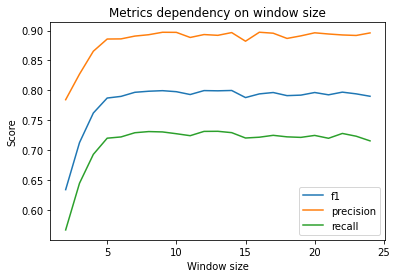

In [8]:
plt.plot(window_sizes, f1_scores, label='f1')
plt.plot(window_sizes, precision_scores, label='precision')
plt.plot(window_sizes, recall_scores, label='recall')
plt.title('Metrics dependency on window size')
plt.xlabel('Window size')
plt.ylabel('Score')
plt.legend()
plt.show()

In [6]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res


f1_scores = []
precision_scores = []
recall_scores = []
window_size = 7
EMBEDDING_LENGTH = 30

for o_weight in tqdm(np.arange(0.05, 1.0000001, 0.05)):
    corpus = Corpus() 

    corpus.fit(df['tokens'], window=window_size)

    glove = Glove(no_components=EMBEDDING_LENGTH, learning_rate=0.05) 
    glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=False)
    glove.add_dictionary(corpus.dictionary)
    for d in all_dfs:
        d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
        d['int_tokens'] = d.apply(find_glove_token, axis=1)
    
    catboost_x_train = []
    catboost_y_train = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_train.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])

    train.apply(prepare_data_for_catboost, axis=1)

    catboost_x_test = []
    catboost_y_test = []

    def prepare_data_for_catboost(x):
        tokenized_text = x['int_tokens']
        for i, token in enumerate(tokenized_text):
            catboost_x_test.append([])
            for shift in range(window_size):
                if i - window_size // 2 + shift < 0 or i - window_size // 2 + shift >= len(tokenized_text) :
                    catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
                else:
                    catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - window_size // 2 + shift]])
            catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])

    test.apply(prepare_data_for_catboost, axis=1)

    cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1] * 15 + [o_weight], iterations=1000)
    cb.fit(catboost_x_train, catboost_y_train)
    pred = cb.predict(catboost_x_test)
    f1_scores.append(f1_score(catboost_y_test, pred, average='weighted', labels=int_labels))
    precision_scores.append(precision_score(catboost_y_test, pred, average='weighted', labels=int_labels))
    recall_scores.append(recall_score(catboost_y_test, pred, average='weighted', labels=int_labels))

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 20/20 [1:23:28<00:00, 250.45s/it]


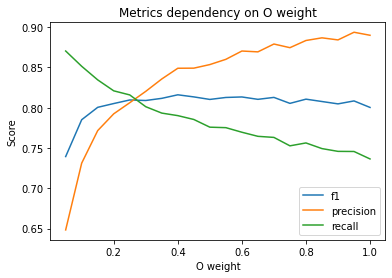

In [7]:
plt.plot(np.arange(0.05, 1.0000001, 0.05), f1_scores, label='f1')
plt.plot(np.arange(0.05, 1.0000001, 0.05), precision_scores, label='precision')
plt.plot(np.arange(0.05, 1.0000001, 0.05), recall_scores, label='recall')
plt.title('Metrics dependency on O weight')
plt.xlabel('O weight')
plt.ylabel('Score')
plt.legend()
plt.show()

## GLOVE (fixed, window=7, O_weight=0.4) + CatBoost

In [13]:
def find_glove_token(x):
    res = []
    for w in x['tokens']:
        if w in glove.dictionary.keys():
            res.append(glove.dictionary[w])
        else:
            res.append(0)
    return res

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(df['tokens'], window=7)

glove = Glove(no_components=30, learning_rate=0.05) 
glove.fit(corpus.matrix, epochs=30, no_threads=8, verbose=True)
glove.add_dictionary(corpus.dictionary)

for d in all_dfs:
    d['encoded_ner_tags'] = d.apply(lambda x: [tag_to_idx[t] for t in x['ner_tags']], axis=1)
    d['int_tokens'] = d.apply(find_glove_token, axis=1)

Performing 30 training epochs with 8 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [14]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 7
catboost_x_train = []
catboost_y_train = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_train.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_train[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_train[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_train.append(tag_to_idx[x['ner_tags'][i]])


train.apply(prepare_data_for_catboost, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
3195    None
3196    None
3197    None
3198    None
3199    None
Length: 3200, dtype: object

In [15]:
EMBEDDING_LENGTH = glove.no_components
WINDOW_SIZE = 7
catboost_x_test = []
catboost_y_test = []

def prepare_data_for_catboost(x):
    tokenized_text = x['int_tokens']
    for i, token in enumerate(tokenized_text):
        catboost_x_test.append([])
        for shift in range(WINDOW_SIZE):
            if i - WINDOW_SIZE // 2 + shift < 0 or i - WINDOW_SIZE // 2 + shift >= len(tokenized_text) :
                catboost_x_test[-1] += [0] * EMBEDDING_LENGTH
            else:
                catboost_x_test[-1] += list(glove.word_vectors[tokenized_text[i - WINDOW_SIZE // 2 + shift]])
        catboost_y_test.append(tag_to_idx[x['ner_tags'][i]])


test.apply(prepare_data_for_catboost, axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
795    None
796    None
797    None
798    None
799    None
Length: 800, dtype: object

In [18]:
cb = CatBoostClassifier(verbose=False, task_type="GPU", class_weights=[1] * 15 + [0.4], iterations=25000)
cb.fit(catboost_x_train, catboost_y_train)
pred = cb.predict(catboost_x_test)

In [19]:
print(metrics.flat_classification_report(
    np.array([label_list[i] for i in catboost_y_test])[..., np.newaxis, np.newaxis], 
    np.array([label_list[i] for i in pred[:, 0]])[..., np.newaxis, np.newaxis], 
    digits=4, 
    labels=labels))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

 B-DOCAGRDATE     0.6807    0.5400    0.6022       150
 I-DOCAGRDATE     0.7191    0.7273    0.7232        88
  B-DOCAGRNUM     0.7188    0.6425    0.6785       179
  I-DOCAGRNUM     1.0000    0.5714    0.7273         7
  B-DOCAMOUNT     0.8507    0.7152    0.7771      1243
  I-DOCAMOUNT     0.7817    0.6871    0.7313       620
    B-DOCCPTY     0.8470    0.8655    0.8562       595
    I-DOCCPTY     0.8731    0.9025    0.8875       564
 B-DOCCPTYINN     0.9442    0.9007    0.9220       282
B-DOCCUSTOMER     0.9707    0.9245    0.9470       609
I-DOCCUSTOMER     0.9581    0.9416    0.9498       462
    B-DOCDATE     0.8631    0.8310    0.8468       645
    I-DOCDATE     0.8825    0.9438    0.9121       605
     B-DOCNUM     0.8367    0.6298    0.7187       651
     I-DOCNUM     0.0000    0.0000    0.0000         0

    micro avg     0.8645    0.8018    0.8320      6700
    macro avg     0.7951    0.7215    0.7520      6700
 weighte